In [33]:
#!pip install pyspark_dist_explore

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as F


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram

%matplotlib inline

In [2]:
from pyspark.sql import SparkSession, SQLContext, Row
my_spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://<user>:<pass>@<URI>/<DB>.reviews_merged") \
    .getOrCreate()

df = my_spark.read.format("mongo").load()

sc = my_spark.sparkContext
sqlContext =  SQLContext(sc, sparkSession=None, jsqlContext=None)

In [3]:
df.printSchema()
df.createOrReplaceTempView("temp")


root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- histogram: struct (nullable = true)
 |    |-- 1 stella: string (nullable = true)
 |    |-- 2 stelle: string (nullable = true)
 |    |-- 3 stelle: string (nullable = true)
 |    |-- 4 stelle: string (nullable = true)
 |    |-- 5 stelle: string (nullable = true)
 |    |-- null: null (nullable = true)
 |-- kind: string (nullable = true)
 |-- next_page: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- reviews: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- content: string (nullable = true)
 |    |    |-- date: string (nullable = true)
 |    |    |-- found_helpful: string (nullable = true)
 |    |    |-- images: string (nullable = true)
 |    |    |-- product: string (nullable = true)
 |    |    |-- ra

In [4]:
from pyspark.sql.functions import explode
df2=df.select('product_title',explode('reviews.rating').alias('rating'))
df3=df.select('product_title',explode('reviews.content').alias('content'))
from pyspark.sql.functions import *
df2 = df2.withColumn('rating', regexp_replace('rating', ',', '.'))
df2=df2.withColumn('rating',df2['rating'].cast("float").alias('ratings'))

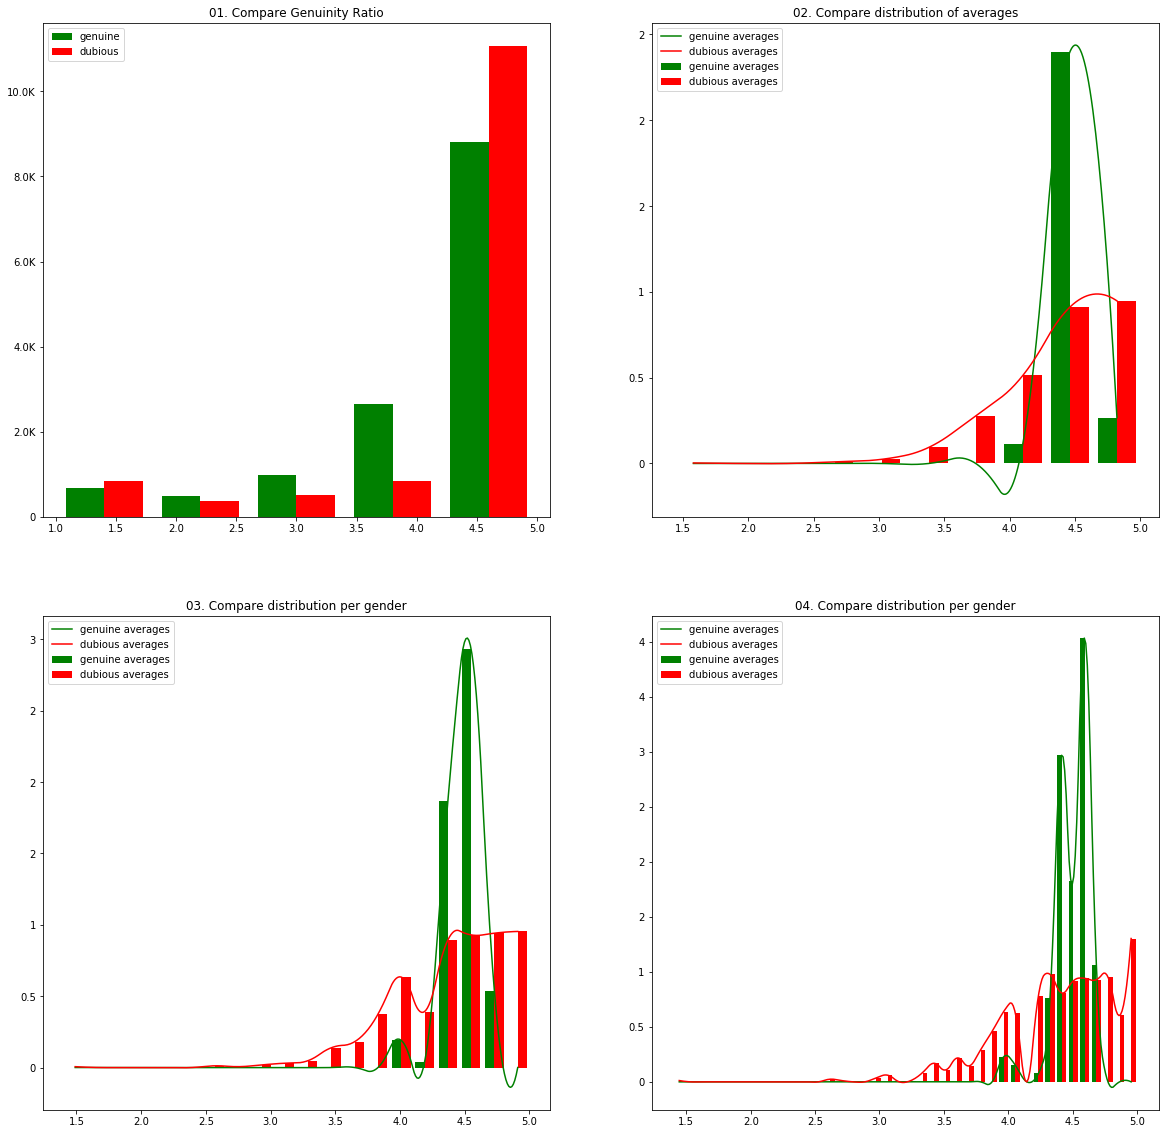

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
# Create some selections on this data

filtered_genuine = df.filter(F.col('kind') == 'genuine').select(explode('reviews.rating').alias('genuine')).na.drop()
num= filtered_genuine.count()
filtered_notgenuine = df.filter(F.col('kind') == 'notgenuine').select(explode('reviews.rating').alias('dubious')).na.drop().limit(num)
filtered_genuine = filtered_genuine.withColumn('genuine', F.regexp_replace('genuine', ',', '.'))
filtered_genuine= filtered_genuine.withColumn('genuine', filtered_genuine['genuine'].cast("float").alias('genuine ratings'))
filtered_notgenuine = filtered_notgenuine.withColumn('dubious', F.regexp_replace('dubious', ',', '.'))
filtered_notgenuine= filtered_notgenuine.withColumn('dubious', filtered_notgenuine['dubious'].cast("float").alias('dubious ratings'))
                                                                                         
genuine_averages = df.filter(F.col('kind') == 'genuine').select(F.col('average_rating').alias('genuine averages')).na.drop()
dubious_averages = df.filter(F.col('kind') == 'notgenuine').select(F.col('average_rating').alias('dubious averages')).na.drop()

# Create the plots

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20, 20)

# Use the hist function to plot histograms on the Axes
hist(axes[0, 0], [filtered_genuine, filtered_notgenuine], bins = 5, color=['green', 'red'])
axes[0, 0].set_title('01. Compare Genuinity Ratio')
axes[0, 0].legend()

# Use the distplot function to plot (scaled) histograms + density plots on the Axes
distplot(axes[0, 1], [genuine_averages, dubious_averages], bins=10, color=['green', 'red'])
axes[0, 1].set_title('02. Compare distribution of averages')
_ = axes[0, 1].legend()

distplot(axes[1, 0], [genuine_averages, dubious_averages], bins=20,  color=['green', 'red'])
axes[1, 0].set_title('03. Compare distribution per gender')
axes[1, 0].legend()

distplot(axes[1, 1], [genuine_averages, dubious_averages], bins=40,  color=['green', 'red'])
axes[1, 1].set_title('04. Compare distribution per gender')
axes[1, 1].legend()


In [6]:
fivestargenuinetexts = filtered_genuine.filter(F.col('genuine') == '5.0').select("genuine")
fourstargenuinetexts = filtered_genuine.filter(F.col('genuine') == '4.0').select("genuine")
threestargenuinetexts = filtered_genuine.filter(F.col('genuine') == '3.0').select("genuine")
twostargenuinetexts = filtered_genuine.filter(F.col('genuine') == '2.0').select("genuine")
onestargenuinetexts = filtered_genuine.filter(F.col('genuine') == '1.0').select("genuine").na.drop()
e=fivestargenuinetexts.count()
d=fourstargenuinetexts.count()
c=threestargenuinetexts.count()
f=twostargenuinetexts.count()
b=onestargenuinetexts.count()
a=e+d+c+f+b
fivestar= (e/a)*100
fourstar= (d/a)*100
threestar= (c/a)*100
twostar= (f/a)*100
onestar= (b/a)*100
print("Percentages for each star rating in genuine products.")
print("5 STARS "," {0:,.2f}".format(fivestar),"%")
print("4 STARS "," {0:,.2f}".format(fourstar), "%")
print("3 STARS "," {0:,.2f}".format(threestar), "%")
print("2 STARS "," {0:,.2f}".format(twostar), "%")
print("1 STAR "," {0:,.2f}".format(onestar), "%")

Percentages for each star rating in genuine products.
5 STARS   64.69 %
4 STARS   19.47 %
3 STARS   7.26 %
2 STARS   3.58 %
1 STAR   5.00 %


In [7]:
df=df.na.drop()
notgenuinetxt = df.filter(F.col('kind') == 'notgenuine').withColumn("reviews",explode("reviews")).select( 
    F.col("reviews.rating").alias("rating")
  )
fivestargenuinetext = notgenuinetxt.filter(F.col('rating') == '5,0').select("rating").na.drop()
fourstargenuinetext = notgenuinetxt.filter(F.col('rating') == '4,0').select("rating").na.drop()
threestargenuinetext = notgenuinetxt.filter(F.col('rating') == '3,0').select("rating").na.drop()
twostargenuinetext = notgenuinetxt.filter(F.col('rating') == '2,0').select("rating").na.drop()
onestargenuinetext = notgenuinetxt.filter(F.col('rating') == '1,0').select("rating").na.drop()
e=fivestargenuinetext.count()
d=fourstargenuinetext.count()
c=threestargenuinetext.count()
f=twostargenuinetext.count()
b=onestargenuinetext.count()
a=e+d+c+f+b
print("Percentages for each star rating in not genuine products.")
print("5 STARS "," {0:,.2f}".format((e/a)*100),"%")
print("4 STARS "," {0:,.2f}".format((d/a)*100), "%")
print("3 STARS "," {0:,.2f}".format((c/a)*100), "%")
print("2 STARS "," {0:,.2f}".format((f/a)*100), "%")
print("1 STAR "," {0:,.2f}".format((b/a)*100), "%")

Percentages for each star rating in not genuine products.
5 STARS   81.53 %
4 STARS   6.26 %
3 STARS   3.62 %
2 STARS   2.54 %
1 STAR   6.05 %


In [8]:
filtered_genuine.agg({"genuine": "avg"}).alias("genuine ratings avg").show()
print("Over ",filtered_genuine.count()," genuine reviews")
filtered_notgenuine.agg({"dubious": "avg"}).alias("dubious ratings avg").show()
print("Over ",filtered_notgenuine.count()," dubious reviews")

genuine_averages.agg({"genuine averages": "avg"}).alias("genuine average ratings average").show()
print("Over ",genuine_averages.count()," genuine products average ratings")

dubious_averages.agg({"dubious averages": "avg"}).alias("dubious average ratings average").show()    
print("Over ",dubious_averages.count()," dubious products average ratings")


+-----------------+
|     avg(genuine)|
+-----------------+
|4.352634286134176|
+-----------------+

Over  13609  genuine reviews
+-----------------+
|     avg(dubious)|
+-----------------+
|4.536777132779778|
+-----------------+

Over  13609  dubious reviews
+---------------------+
|avg(genuine averages)|
+---------------------+
|    4.497260273972601|
+---------------------+

Over  146  genuine products average ratings
+---------------------+
|avg(dubious averages)|
+---------------------+
|    4.403908794788278|
+---------------------+

Over  921  dubious products average ratings


Creating Sample

In [9]:
genuine= df.filter(F.col('kind') == 'genuine').select("average_rating").sample(False, 0.5, 42).na.drop()
notgenuine= df.filter(F.col('kind') == 'notgenuine').select("average_rating").sample(False, 0.5, 42).na.drop()

filtered_genuine = df.filter(F.col('kind') == 'genuine').select(explode('reviews.rating').alias('rating')).sample(False, 0.5).na.drop()

filtered_genuine = filtered_genuine.withColumn('rating', F.regexp_replace('rating', ',', '.'))
filtered_genuine= filtered_genuine.withColumn('rating', filtered_genuine['rating'].cast("float").alias('genuine ratings'))

filtered_notgenuine = df.filter(F.col('kind') == 'notgenuine').select(explode('reviews.rating').alias('rating')).sample(False, 0.5).na.drop()

filtered_notgenuine = filtered_notgenuine.withColumn('rating', F.regexp_replace('rating', ',', '.'))
filtered_notgenuine= filtered_notgenuine.withColumn('rating', filtered_notgenuine['rating'].cast("float").alias('notgenuine ratings'))


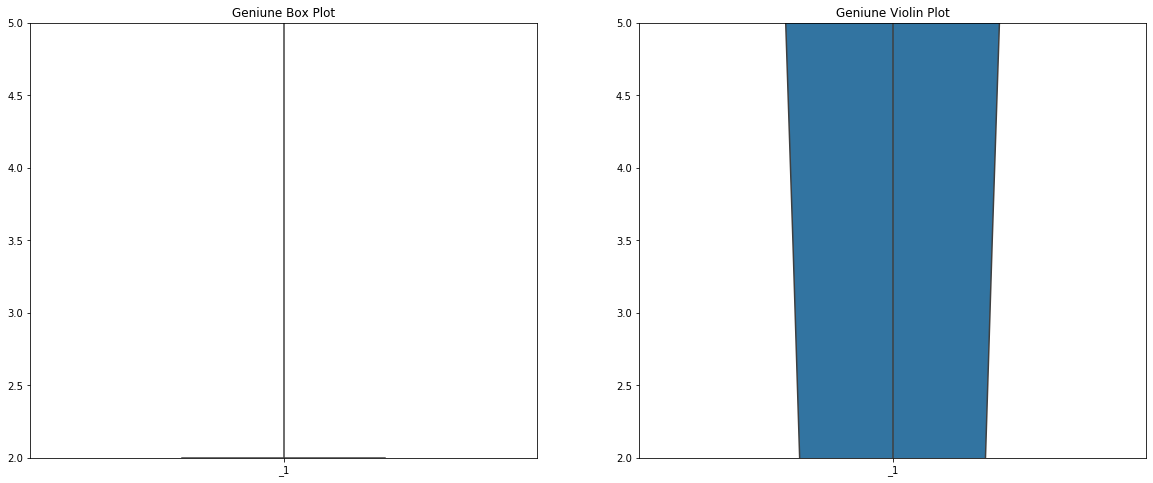

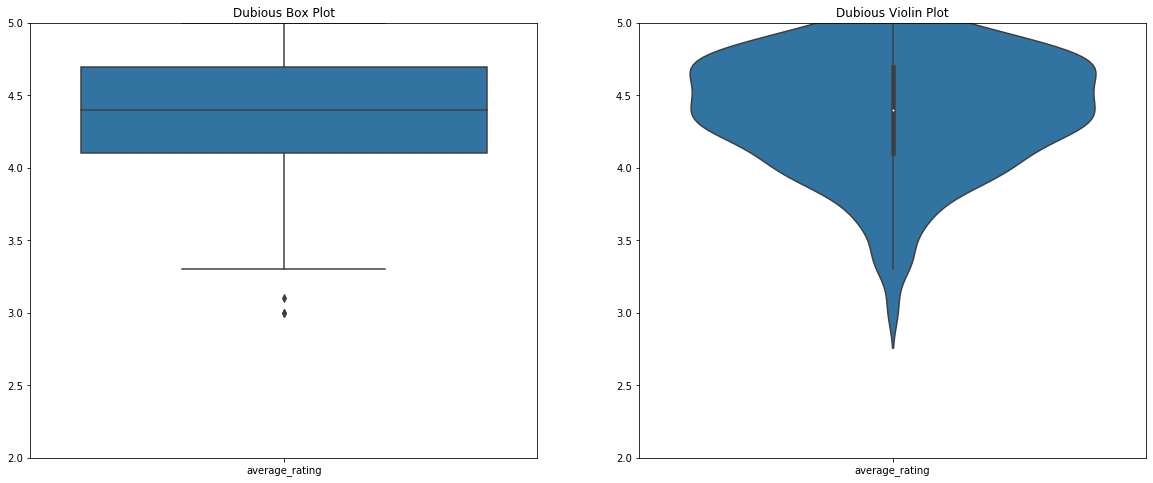

In [18]:
x = genuine.toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1).set_ylim(2, 5)
ax = sns.boxplot(data=x).set_title('Geniune Box Plot')

ax = fig.add_subplot(1, 2, 2).set_ylim(2, 5)
ax = sns.violinplot(data=x).set_title('Geniune Violin Plot')

x = notgenuine.toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1).set_ylim(2, 5)
ax = sns.boxplot(data=x).set_title('Dubious Box Plot')

ax = fig.add_subplot(1, 2, 2).set_ylim(2, 5)
ax = sns.violinplot(data=x).set_title('Dubious Violin Plot')

Preprocessing for Machine Learning

In [11]:
somegenuinetext = df.filter(F.col('kind') == 'genuine').select(explode('reviews.content').alias('text'))

somegenuinetxt = df.filter(F.col('kind') == 'genuine').withColumn("reviews",explode("reviews")).select(
    F.col("reviews.content").alias("text"), 
    F.col("reviews.rating").alias("rating")
  )

fivestargenuinetext = somegenuinetxt.filter(F.col('rating') == '5,0').select("text").na.drop()
def lower_clean_str(x):
    lowercased_str = x[0].lower()
    punc = '!"#$%@^&*()\'?/:;><.,'
    for ch in punc:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str.split(' ')

fivestargenuinetextlen = fivestargenuinetext.rdd.map(lower_clean_str).map(len)

In [12]:
somedubioustxt = df.filter(F.col('kind') == 'notgenuine').withColumn("reviews",explode("reviews")).select(
    F.col("reviews.content").alias("text"), 
    F.col("reviews.rating").alias("rating")
  )

fivestardubioustext = somedubioustxt.filter(F.col('rating') == '5,0').select("text").na.drop()
fivestardubioustextlen = fivestardubioustext.rdd.map(lower_clean_str).map(len)

In [13]:
genuine= fivestargenuinetextlen.map(lambda x: (x, )).toDF().sample(False, 0.8, 42).limit(500)
dubious= fivestardubioustextlen.map(lambda x: (x, )).toDF().sample(False, 0.5, 42).limit(500)

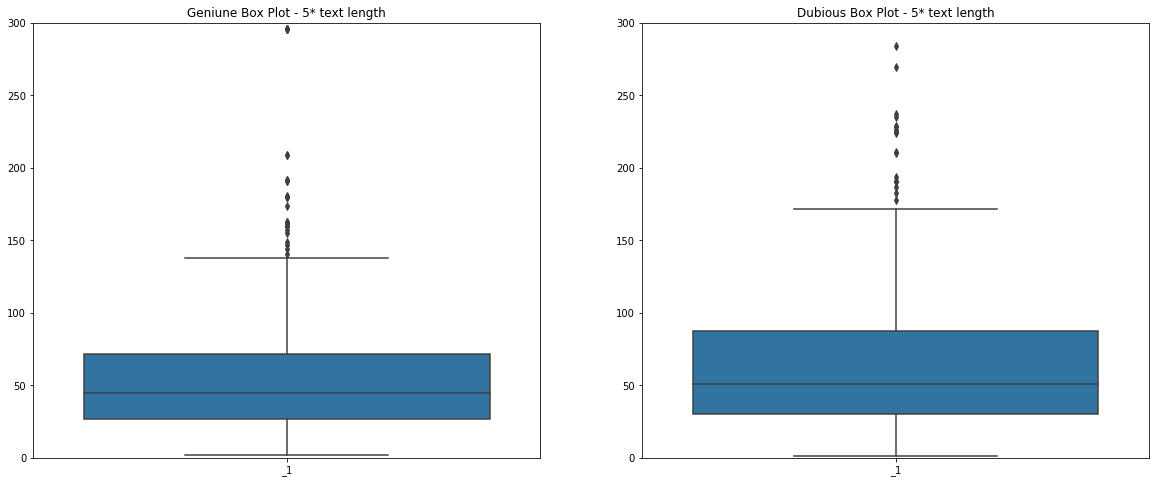

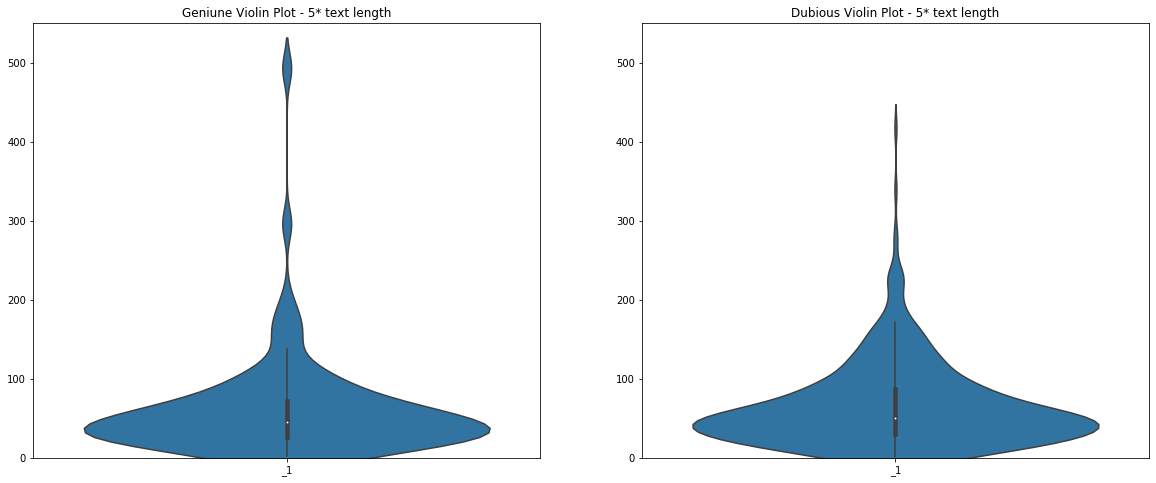

In [17]:
x = genuine.toPandas()
y = dubious.toPandas()

fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 2, 1).set_ylim(0, 300)
ax = sns.boxplot(data=x).set_title('Geniune Box Plot - 5* text length')

ax = fig.add_subplot(1, 2, 2).set_ylim(0, 300)
ax = sns.boxplot(data=y).set_title('Dubious Box Plot - 5* text length')

fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 2, 1).set_ylim(0, 550)
ax = sns.violinplot(data=x).set_title('Geniune Violin Plot - 5* text length')

ax = fig.add_subplot(1, 2, 2).set_ylim(0, 550)
ax = sns.violinplot(data=y).set_title('Dubious Violin Plot - 5* text length')

In [15]:
onestargenuinetext = somegenuinetxt.filter(F.col('rating') == '1,0').select("text").na.drop()
onestardubioustext = somedubioustxt.filter(F.col('rating') == '1,0').select("text").na.drop()

onestargenuinetextlen = onestargenuinetext.rdd.map(lower_clean_str).map(len)
onestardubioustextlen = onestardubioustext.rdd.map(lower_clean_str).map(len)

In [20]:
genuine= onestargenuinetextlen.map(lambda x: (x, )).toDF().sample(False, 0.8, 42).limit(500)
dubious= onestardubioustextlen.map(lambda x: (x, )).toDF().sample(False, 0.5, 42).limit(500)

In [ ]:
x = genuine.toPandas()
y = dubious.toPandas()

fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(1, 2, 1).set_ylim(0, 220)
ax = sns.boxplot(data=x).set_title('Geniune Box Plot - 1* text length')

ax = fig.add_subplot(1, 2, 2).set_ylim(0, 220)
ax = sns.boxplot(data=y).set_title('Dubious Box Plot - 1* text length')

Data for Machine Learning with 5*

In [30]:
data = df.withColumn("reviews",explode("reviews")).select(
    F.col("reviews.content").alias("text"), 
    F.col("reviews.rating").alias("rating"),
    F.col("kind")
  ).sample(False, 0.5).na.drop().filter(F.col('rating') == '5,0')

data = data.select(F.col("text"), F.col("kind")).toPandas()
print(data.head())
data = data[data['text'].notna()]

size = 800       # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
eq_data = data.groupby('kind', as_index=False).apply(fn)

# CLASSIFICATION
data_classes = eq_data[(eq_data['kind']=="genuine") | (eq_data['kind']=="notgenuine")]

# Seperate the dataset into X and Y for prediction
x = data_classes['text']
y = data_classes['kind']

                                                text     kind
0  Ed ecco lo zaino fotografico AmazonBasics a cu...  genuine
1  La spedizione è stata veloce. Lo zaino era ima...  genuine
2  Le 5* sono meritate dal fatto che sia uno dei ...  genuine
3  Dubbioso ...ma allettato da recensioni positiv...  genuine
4  Ne ho acquistati due per trasportare materiale...  genuine


In [31]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
import math

piccl=0
# CLEANING THE REVIEWS - REMOVAL OF STOPWORDS AND PUNCTUATION
def text_process(text):
    global piccl
    piccl=piccl+1
    exclude = set(string.punctuation)
    nopunc = [ch for ch in text if ch not in exclude]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('italian')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# CONVERTING THE WORDS INTO A VECTOR
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score

vocab = CountVectorizer(analyzer=text_process).fit(x[0])
print(len(vocab.vocabulary_))
r0 = x[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0)
"""
    Now the words in the review number 78 have been converted into a vector.
    The data that we can see is the transformed words.
    If we now get the feature's name - we can get the word back!
"""
print("Getting the words back:")
print(vocab.get_feature_names()[400])
print(vocab.get_feature_names()[700])

6456
2390    Borsa porta pc molto funzionale e ben progetta...
3145    Cotone ottimo, colore brillante, perlomeno al ...
3964    Belle lenzuola con angoli  sono fatte  bene so...
1726    Anche questi articoli di cancelleria AmazonBas...
3817    Cotone morbido, fresco anche d'estate, veramen...
                              ...                        
1300    Pile molto conveniente ma ottime allo stesso m...
4203    Prezzo ottimo per un prodotto che fa benissimo...
1479    Molto soddisfatto del prodotto (anche se siamo...
2566    Veramente un pezzo di arredamento in cucina mo...
3207    La sua lucentezza il colore sembra quello dei ...
Name: text, Length: 800, dtype: object
  (0, 3)	21
  (0, 4)	16
  (0, 5)	1
  (0, 6)	4
  (0, 9)	1
  (0, 10)	2
  (0, 15)	1
  (0, 20)	13
  (0, 21)	1
  (0, 22)	1
  (0, 26)	1
  (0, 27)	1
  (0, 30)	1
  (0, 31)	1
  (0, 32)	3
  (0, 35)	9
  (0, 36)	1
  (0, 37)	1
  (0, 39)	1
  (0, 49)	1
  (0, 50)	1
  (0, 51)	1
  (0, 53)	1
  (0, 56)	1
  (0, 57)	5
  :	:
  (0, 6418)	1


In [33]:
x = vocab.transform(x)
#Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)

# DENSITY OF THE MATRIX
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (1600, 6456)
Non-Zero occurences:  42194
Density of the matrix =  0.40847661090458487


In [35]:
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=101)

In [36]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
preddt = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))
print("Classification Report:",classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
[[158  82]
 [ 77 163]]
Classification Report:               precision    recall  f1-score   support

     genuine       0.67      0.66      0.67       240
  notgenuine       0.67      0.68      0.67       240

    accuracy                           0.67       480
   macro avg       0.67      0.67      0.67       480
weighted avg       0.67      0.67      0.67       480



In [37]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[151  89]
 [ 37 203]]
Classification Report:
              precision    recall  f1-score   support

     genuine       0.80      0.63      0.71       240
  notgenuine       0.70      0.85      0.76       240

    accuracy                           0.74       480
   macro avg       0.75      0.74      0.73       480
weighted avg       0.75      0.74      0.73       480



In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train,y_train)
predknn = knn.predict(x_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
print("Classification Report:")
print(classification_report(y_test,predknn))

Confusion Matrix for K Neighbors Classifier:
[[114 126]
 [ 87 153]]
Classification Report:
              precision    recall  f1-score   support

     genuine       0.57      0.47      0.52       240
  notgenuine       0.55      0.64      0.59       240

    accuracy                           0.56       480
   macro avg       0.56      0.56      0.55       480
weighted avg       0.56      0.56      0.55       480



In [39]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Classification Report:",classification_report(y_test,predrmfr))

C:\Users\Mica\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion Matrix for Random Forest Classifier:
[[146  94]
 [ 53 187]]
Classification Report:               precision    recall  f1-score   support

     genuine       0.73      0.61      0.67       240
  notgenuine       0.67      0.78      0.72       240

    accuracy                           0.69       480
   macro avg       0.70      0.69      0.69       480
weighted avg       0.70      0.69      0.69       480



Data for Machine Learning with 1* and 2* reviews

In [41]:
databad = df.withColumn("reviews",explode("reviews")).select(
    F.col("reviews.content").alias("text"), 
    F.col("reviews.rating").alias("rating"),
    F.col("kind")
  ).na.drop()

databad = databad.filter((F.col('rating') == '1,0') | (F.col('rating') == '2,0')).select(F.col("text"), F.col("kind")).toPandas()
databad.text = databad.text.tolist()
print(databad.head())
databad = databad[databad['text'].notna()]

# CLASSIFICATION
data_classes = databad
data_classes.head()
print(data_classes.shape)

# Seperate the dataset into X and Y for prediction
x = data_classes['text']
y = data_classes['kind']

                                                text     kind
0  È uno zaino molto capiente e gli spallacci son...  genuine
1  Le chiusure lampo dovrebbero avere l'occhiello...  genuine
2  Ho questo zaino da un paio di mesi e le bretel...  genuine
3  È uno zaino molto capiente e gli spallacci son...  genuine
4  Le chiusure lampo dovrebbero avere l'occhiello...  genuine
(3620, 2)


In [42]:
# CONVERTING THE WORDS INTO A VECTOR
vocab = CountVectorizer(analyzer=text_process).fit(x)
print(len(vocab.vocabulary_))
r0 = x[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0)
print("Getting the words back:")
print(vocab.get_feature_names()[400])
print(vocab.get_feature_names()[700])

13371
È uno zaino molto capiente e gli spallacci sono larghi e morbidi da portare, l'imbottitura dello schienale é buona e traspirante. Per quanto riguarda i difetti devo dire che l'interno é costruito con materiale economico, il tessuto non è molto aderente e la conformazione interna dello zaino(profondo 8 cm. in alto e 13cm. in basso)  limita la disposizione sia degli obiettivi che dei settori imbottiti. Essendo molto grande avrei diviso le aperture almeno in due, una apertura sola é scomoda. Con il peso degli accessori, aprendo lo zaino, questo tende a deformarsi.
  (0, 41)	1
  (0, 255)	1
  (0, 2276)	1
  (0, 2396)	1
  (0, 2614)	1
  (0, 2635)	1
  (0, 2783)	1
  (0, 2784)	1
  (0, 2880)	1
  (0, 3308)	1
  (0, 3551)	1
  (0, 3698)	1
  (0, 4055)	1
  (0, 4314)	1
  (0, 4650)	1
  (0, 4898)	1
  (0, 5090)	1
  (0, 5123)	1
  (0, 5194)	1
  (0, 5277)	1
  (0, 5351)	1
  (0, 5452)	1
  (0, 5529)	1
  (0, 6505)	1
  (0, 6636)	1
  (0, 7085)	1
  (0, 7293)	1
  (0, 7505)	1
  (0, 7507)	1
  (0, 7543)	1
  (0, 793

In [43]:
x = vocab.transform(x)
#Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)

# DENSITY OF THE MATRIX
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (3620, 13371)
Non-Zero occurences:  82780
Density of the matrix =  0.17102238661967786


In [44]:
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=101)

In [45]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
preddt = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))
print("Classification Report:",classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
[[291  61]
 [ 69 665]]
Classification Report:               precision    recall  f1-score   support

     genuine       0.81      0.83      0.82       352
  notgenuine       0.92      0.91      0.91       734

    accuracy                           0.88      1086
   macro avg       0.86      0.87      0.86      1086
weighted avg       0.88      0.88      0.88      1086



In [46]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[284  68]
 [ 32 702]]
Classification Report:
              precision    recall  f1-score   support

     genuine       0.90      0.81      0.85       352
  notgenuine       0.91      0.96      0.93       734

    accuracy                           0.91      1086
   macro avg       0.91      0.88      0.89      1086
weighted avg       0.91      0.91      0.91      1086



In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train,y_train)
predknn = knn.predict(x_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
print("Classification Report:")
print(classification_report(y_test,predknn))

Confusion Matrix for K Neighbors Classifier:
[[ 83 269]
 [ 20 714]]
Classification Report:
              precision    recall  f1-score   support

     genuine       0.81      0.24      0.36       352
  notgenuine       0.73      0.97      0.83       734

    accuracy                           0.73      1086
   macro avg       0.77      0.60      0.60      1086
weighted avg       0.75      0.73      0.68      1086



In [48]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Classification Report:",classification_report(y_test,predrmfr))

C:\Users\Mica\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Confusion Matrix for Random Forest Classifier:
[[278  74]
 [ 55 679]]
Classification Report:               precision    recall  f1-score   support

     genuine       0.83      0.79      0.81       352
  notgenuine       0.90      0.93      0.91       734

    accuracy                           0.88      1086
   macro avg       0.87      0.86      0.86      1086
weighted avg       0.88      0.88      0.88      1086

